# QR Decomposition

In [3]:
3%2 == 0

False

In [5]:
H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
H_4q = np.kron(np.kron(np.kron(H_single, H_single),H_single),H_single)

print(H_4q)

NameError: name 'np' is not defined

In [19]:
import numpy as np

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):

    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

import numpy as np
from numpy.linalg import norm

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):

    U = np.asarray(U)
    dim = U.shape[0]

    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        return (0,0), 0, 0

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    c = U[i, i].real        
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   

    return (i, j), fraction, phi

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0
    count = 0
    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate", i, theta, col))
        rotation_mats.append(G)
    

    for col in order:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap", col, theta_swap, col))
        rotation_mats.append(G_swap)
        count += 1 
        if count % 2 == 0:
            for i in order[count:][::-1]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
        else:
            for i in order[count:]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats

import numpy as np

import numpy as np

def givens_rotation_complex(m, j, theta, phi):
    c = np.cos(theta/2)
    s = np.sin(theta/2)
    G = np.eye(m, dtype=complex)
    G[0, 0] = c
    G[0, j] = np.exp(1j*phi)*s
    G[j, 0] = -np.exp(-1j*phi)*s
    G[j, j] = c
    return G

def star_qr_decomposition_complex(order, U, tol=1e-10):
    m = U.shape[0]
    V = U.copy()
    info = []
    mats = []
    col = 0
    for j in order[::-1]:
        a = V[0, col]
        b = V[j, col]
        if abs(b) < tol:
            continue
        theta = 2*np.arctan2(abs(b), abs(a))
        phi = np.angle(a) - np.angle(b)
        G = givens_rotation_complex(m, j, theta, phi)
        V = G @ V
        info.append(("rotate", j, theta, phi, col))
        mats.append(G)
    cnt = 0
    for col in order:
        Gs = givens_rotation_complex(m, col, np.pi/2, 0.0)
        V = Gs @ V
        info.append(("swap", col, np.pi/2, 0.0, col))
        mats.append(Gs)
        cnt += 1
        seq = order[cnt:][::-1] if cnt % 2 == 0 else order[cnt:]
        for j in seq:
            a = V[0, col]
            b = V[j, col]
            if abs(b) < tol:
                continue
            theta = 2*np.arctan2(abs(b), abs(a))
            phi = np.angle(a) - np.angle(b)
            G = givens_rotation_complex(m, j, theta, phi)
            V = G @ V
            info.append(("rotate", j, theta, phi, col))
            mats.append(G)
        V = Gs @ V
        info.append(("swap_back", col, np.pi/2, 0.0, col))
        mats.append(Gs)
    return info, V, mats



# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 8
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# U = np.real(unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim))

U = np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))
# U = np.real(np.array([[ 1.        -0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j],
#        [ 0.        +0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339+0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j,
#         -0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339+0.j,
#         -0.35355339-0.j, -0.35355339-0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339-0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j]]))
# U = np.real(np.array([
#     [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
#     [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
#     [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
#     [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
# ], dtype=complex))

import itertools

my_list = [1,2,3,4,5,6,7]
permutations = list(itertools.permutations(my_list))
permutations = [my_list]
list_lens = []
list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    # coup, f, ph = inverse_single_pulse(compressed[13])
    # print(f)
    # if len(compressed) < len_comp:
    #     print(len(compressed))
        # list_comp.append(compressed)
        # len_comp = len(compressed)
    # print(V_triangular)
    couplings = []
    phases = []
    fractions = []
    # print(len(rotation_mats))
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    # if couplings[0:6]==couplings[7:13][::-1]:
    # # if 3%np.round(fractions[0],2) == 0 and 3%np.round(fractions[12],2) == 0 and np.round(fractions[12],2) != 1:   
    # print('couplings = ',couplings)
    # print('fractions = ', fractions)
    # print('phases = ', phases)
# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    U_reconstructed = np.eye(dim)
    for G in reversed(compressed[:]):
        U_reconstructed = G.T @ U_reconstructed
    # print(U_reconstructed)
    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    a = np.round(np.abs(U_reconstructed),3).tolist()
    b = np.round(np.abs(U),3).tolist()
    list_lens.append(len(couplings))
    # if len(couplings) == 36:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
print('done')

____________________________This works_____________________________________ 40
couplings =  [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 1), (0, 2), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 3), (0, 4), (0, 7), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 5), (0, 6), (0, 7), (0, 6), (0, 0)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.5456289483429901, 0.4195693767448337, 0.2951672353008666, 0.33333333333333326, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 1.0, 0.2163468959387855, 0.33333333333333337, 0.2951672353008666, 0.4195693767448337, 1.0, 1.0, 0.5640942168489749, 0.5, 0.5, 0.3918265520306073, 1.0, 1.0, 1.3918265520306072, 0.28043779800754365, 0.18642949867733732, 1.0, 1.0, 1.214292504567932, 0.26772047280122996, 1.0, 1.0, 1.7048327646991335, 1.0, 0]
phases =

In [ ]:
import numpy as np

def unitary_decomposition(U, tol=1e-10):
    """
    Decomposes a unitary matrix U into a series of complex Givens rotations
    and a diagonal matrix D, such that U = G_1 G_2 ... G_k D.

    Args:
        U (np.ndarray): The complex unitary matrix to decompose.
        tol (float): A tolerance for checking if an element is zero.

    Returns:
        tuple: A tuple containing:
            - rotations (list): A list of dictionaries, where each dictionary
              describes a Givens rotation G_i. The list is ordered [G_1, G_2, ...].
            - D (np.ndarray): A 1D array representing the final diagonal matrix.
    """
    m, n = U.shape
    if m != n:
        raise ValueError("Matrix must be square.")
    if not np.allclose(U @ U.conj().T, np.eye(m)):
        print("Warning: Input matrix may not be unitary.")

    V = U.copy().astype(np.complex128)
    applied_rotations = []

    # Zero out the lower triangle of the matrix column by column
    for j in range(n):  # Column index
        for i in range(m - 1, j, -1):  # Row index (from bottom up)
            # Elements to be rotated
            a = V[i - 1, j]
            b = V[i, j]

            if np.abs(b) < tol:
                continue

            # Calculate the parameters for the complex Givens rotation
            # that will zero out element b (V[i, j]).
            r = np.hypot(np.abs(a), np.abs(b))
            c = a / r
            s = b / r
            
            # We apply G_inv to V, where the 2x2 part is [[c*, s*], [-s, c]].
            # This is applied to rows i-1 and i.
            row1 = V[i - 1, j:].copy()
            row2 = V[i, j:].copy()
            V[i - 1, j:] = c.conj() * row1 + s.conj() * row2
            V[i, j:] = -s * row1 + c * row2

            # We store the parameters for the forward rotation G = G_inv^dagger.
            # U = G_1 G_2 ... G_k D.
            applied_rotations.append({'rows': (i - 1, i), 'params': (c, s)})

    # The resulting matrix V is now diagonal
    D = np.diagonal(V)
    
    # The rotations must be applied in reverse order of how they were found.
    return list(reversed(applied_rotations)), D

def reconstruct_unitary(rotations, D):
    """
    Reconstructs the unitary matrix from its decomposition.

    Args:
        rotations (list): The list of Givens rotation parameters from the
                          decomposition function.
        D (np.ndarray): The diagonal matrix from the decomposition.

    Returns:
        np.ndarray: The reconstructed unitary matrix.
    """
    m = len(D)
    # Start with the diagonal matrix
    U_reconstructed = np.diag(D).astype(np.complex128)

    # Apply the Givens rotations in the specified order (G_1, then G_2, etc.)
    for rot in rotations:
        i, j = rot['rows']
        c, s = rot['params']
        
        # Build the Givens rotation G (Hermitian conjugate of the one applied)
        G = np.eye(m, dtype=np.complex128)
        G[i, i] = c
        G[i, j] = -s.conj()
        G[j, i] = s
        G[j, j] = c.conj()

        U_reconstructed = G @ U_reconstructed
        
    return U_reconstructed

In [20]:
print(min(list_lens))

32


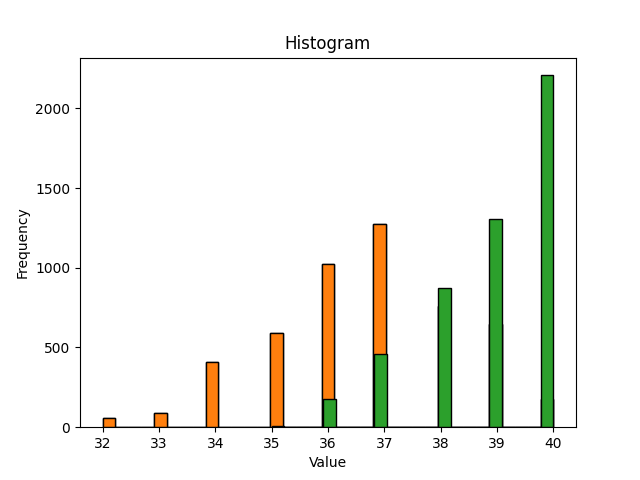

In [34]:
import matplotlib.pyplot as plt
plt.hist(list_lens, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

In [14]:
%matplotlib widget

In [32]:
import numpy as np

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    """
    Detect where adjacent rotation matrices act on the same pair of levels.

    Assumes each matrix in `rotation_mats` is a unitary generated by a pulse
    that couples level 0 with some other level j.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices for individual pulses.

    Returns
    -------
    matches : list of int
        List of 0 or 1 where 1 indicates adjacent couplings act on the same (0, j).
        Length is len(rotation_mats) - 1.
    """
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

import numpy as np
from numpy.linalg import norm

def compress_rotations(rotation_mats, tol=1e-8):
    """
    Optimize a sequence of rotations by combining adjacent ones acting on the same subspace.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices representing individual pulses.

    Returns
    -------
    optimized_mats : list of np.ndarray
        Compressed list with redundant or canceling rotations removed.
    """
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):
    """
    Infer (i, j, fraction f, phase φ) for a unitary generated by ONE pulse of the form

        U = exp[‑i (Ω t /2) ( |i⟩⟨j| e^{+iφ} + |j⟩⟨i| e^{-iφ} )]

    Parameters
    ----------
    U   : (dim, dim) unitary ndarray
    tol : numerical tolerance for zero / equality tests

    Returns
    -------
    coupling  : tuple  (i, j)
    fraction  : float  f  (θ = π f,  0 ≤ f ≤ 2)
    phase     : float  φ  in the range 0 ≤ φ < 2π

    Raises
    ------
    ValueError if `U` is not compatible with a single pulse.
    """
    
    U = np.asarray(U)
    dim = U.shape[0]

    # --- locate the only non‑trivial 2×2 block -----------------------------
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        # raise ValueError("The matrix is not generated by a single two‑level pulse.")
        return (0,0), 0, 0

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    # --- extract rotation angle θ and phase φ -----------------------------
    c = U[i, i].real          # should equal U[j, j] and be real
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    # off‑diagonal element gives φ   (U_ij = –i sin(θ/2) e^{+iφ})
    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   # shift removes the –i factor

    return (i, j), fraction, phi

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0
    count = 0
    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate", i, theta, col))
        rotation_mats.append(G)
    

    for col in order:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap", col, theta_swap, col))
        rotation_mats.append(G_swap)
        count += 1 
        # if count % 2 == 0:
        for i in order[count:][::-1]:#range(1, m):
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            theta = np.arctan2(b, a)
            G = givens_rotation(m, i, theta)
            V = G @ V
            rotations_info.append(("rotate", i, theta, col))
            rotation_mats.append(G)

        V = G_swap @ V   
        rotations_info.append(("swap_back", col, theta_swap, col))
        rotation_mats.append(G_swap)
        # else:
        #     for i in order[count:]:#range(1, m):
        #         a = V[0, col]
        #         b = V[i, col]
        #         if np.abs(b) < tol:
        #             continue
        #         theta = np.arctan2(b, a)
        #         G = givens_rotation(m, i, theta)
        #         V = G @ V
        #         rotations_info.append(("rotate", i, theta, col))
        #         rotation_mats.append(G)
    
        #     V = G_swap @ V   
        #     rotations_info.append(("swap_back", col, theta_swap, col))
        #     rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats



# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 4
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
H_4q = np.kron(H_single, H_single)

print(H_4q)
# print(uisgfy)
U = -1*np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))

U = -1*np.real(H_4q)

import itertools

my_list = [1,2,3]
permutations = list(itertools.permutations(my_list))

list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    # coup, f, ph = inverse_single_pulse(compressed[13])
    # print(f)
    # if len(compressed) < len_comp:
    #     print(len(compressed))
        # list_comp.append(compressed)
        # len_comp = len(compressed)
    couplings = []
    phases = []
    fractions = []
    # print(len(rotation_mats))
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    # if couplings[0:6]==couplings[7:13][::-1]:
    # # if 3%np.round(fractions[0],2) == 0 and 3%np.round(fractions[12],2) == 0 and np.round(fractions[12],2) != 1:   
    # print('couplings = ',couplings)
    # print('fractions = ', fractions)
    # print('phases = ', phases)
# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    U_reconstructed = np.eye(dim)
    for G in reversed(compressed[:]):
        U_reconstructed = G.T @ U_reconstructed
    
    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    a = np.round(np.abs(U_reconstructed),3).tolist()
    b = np.round(np.abs(U),3).tolist()
    if a==b:
        print('____________________________This works_____________________________________',len(couplings))
        print('couplings = ',couplings)
        print('fractions = ', fractions)
        print('phases = ', phases)
print('done')

[[ 0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5-0.j]]
____________________________This works_____________________________________ 10
couplings =  [(0, 3), (0, 2), (0, 1), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 2), (0, 0)]
fractions =  [1.5, 0.3918265520306073, 0.6666666666666667, 0.564094216848975, 0.2677204728012301, 1.0, 1.0, 0.7048327646991335, 1.0, 0]
phases =  [1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.0]
____________________________This works_____________________________________ 9
couplings =  [(0, 2), (0, 3), (0, 1), (0, 3), (0, 1), (0, 3), (0, 2), (0, 3), (0, 0)]
fractions =  [1.5, 0.3918265520306073, 0.6666666666666667, 0.6081734479693928, 1.0, 1.0, 1.5, 1.0, 0]
phases =  [1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.0]
____________________________This works_____________________________________ 10
couplings =  [(0, 3), (0, 1), (0, 2), (0, 3), (0, 1), (0, 2), (0, 1), (0

In [91]:
import numpy as np
from numpy.linalg import norm
import itertools
from math import acos, pi

def givens_rotation(d, j, θ):
    G = np.eye(d, dtype=complex)
    c, s = np.cos(θ), np.sin(θ)
    G[0, 0] = c; G[0, j] = s; G[j, 0] = -s; G[j, j] = c
    return G

def _leaf(U, tol):
    for j in range(1, U.shape[0]):
        if abs(U[0, j]) > tol or abs(U[j, 0]) > tol:
            return j
    return None

def _fuse(L, G, tol):
    if not L:
        L.append(G); return
    j1 = _leaf(G, tol); j0 = _leaf(L[-1], tol)
    if j1 is not None and j1 == j0:
        H = G @ L[-1]
        if norm(H - np.eye(H.shape[0])) < tol:
            L.pop()
        else:
            L[-1] = H
    else:
        L.append(G)

def star_qr_decomposition(U, order=None, tol=1e-10):
    V = U.copy().astype(complex)
    d = V.shape[0]
    if order is None:
        order = list(range(d - 1, 0, -1))
    R = []
    for j in order:
        b = V[j, 0]
        if abs(b) < tol:
            continue
        θ = np.arctan2(abs(b), abs(V[0, 0]))
        G = givens_rotation(d, j, θ)
        V = G @ V
        _fuse(R, G, tol)
    for col, jp in enumerate(order, 1):
        a = V[0, col]
        if abs(a) >= tol:
            θ = -np.arctan2(abs(a), np.real(V[0, 0]))
            G = givens_rotation(d, jp, θ)
            V = G @ V
            _fuse(R, G, tol)
        for j in order[: order.index(jp)]:
            b = V[j, col]
            if abs(b) < tol:
                continue
            θ = np.arctan2(abs(b), abs(V[0, col]))
            G = givens_rotation(d, j, θ)
            V = G @ V
            _fuse(R, G, tol)
    return R, V

# def inverse_single_pulse(U, tol=1e-8):
#     d = U.shape[0]
#     cands = [(p, q) for p in range(d) for q in range(p + 1, d)
#              if abs(U[p, q]) > tol or abs(U[q, p]) > tol]
#     if len(cands) != 1:
#         return (0, 0), 0, 0
#     i, j = cands[0]
#     c = max(min(np.real(U[i, i]), 1.0), -1.0)
#     θ = 2 * acos(c)
#     f = θ / pi
#     φ = (np.angle(U[i, j]) + pi / 2) % (2 * pi)
#     return (i, j), f, φ

def inverse_single_pulse(U, *, tol= 1e-8):

    U = np.asarray(U)
    dim = U.shape[0]

    # --- locate the only non‑trivial 2×2 block -----------------------------
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        # raise ValueError("The matrix is not generated by a single two‑level pulse.")
        return (0,0), 0, 0

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    # --- extract rotation angle θ and phase φ -----------------------------
    c = U[i, i].real          # should equal U[j, j] and be real
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    # off‑diagonal element gives φ   (U_ij = –i sin(θ/2) e^{+iφ})
    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   # shift removes the –i factor

    return (i, j), fraction, phi

if __name__ == "__main__":
    dim = 4
    H = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=complex)
    U_target = -np.real(np.kron(H, H))
    best_len, best = None, None
    for order in itertools.permutations(range(1, dim)):
        rot, V = star_qr_decomposition(U_target, order=list(order))
        if best_len is None or len(rot) < best_len:
            best_len, best = len(rot), (order, rot, V)
    order, rotations, V = best
    Q_dag = np.eye(dim, dtype=complex)
    U_rec = np.eye(dim, dtype = complex)
    for G in reversed(rotations):
        print(G)
        U_rec = G.conj().T @ U_rec
        Q_dag = G.conj().T @ Q_dag
    print(U_rec)
    print("order:", order)
    print("gate_count:", len(rotations))
    print("reconstruction_error:", norm(U_rec - U_target))
    print("U_reconstructed:\n", np.round(U_rec, 3))
    print("U_target:\n", np.round(U_target, 3))
    couplings, fractions, phases = [], [], []
    for G in reversed(rotations):
        (i, j), f, φ = inverse_single_pulse(G.conj().T)
        couplings.append((i, j))
        fractions.append(f)
        phases.append(φ / pi)
    print("couplings=", couplings)
    print("fractions=", fractions)
    print("phases=", phases)


[[ 0.866+0.j  0.   +0.j  0.5  +0.j  0.   +0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [-0.5  +0.j  0.   +0.j  0.866+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  1.   +0.j]]
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[ 0.866+0.j  0.   +0.j  0.   +0.j  0.5  +0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  1.   +0.j  0.   +0.j]
 [-0.5  +0.j  0.   +0.j  0.   +0.j  0.866+0.j]]
[[ 0.816+0.j  0.   +0.j  0.577+0.j  0.   +0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [-0.577+0.j  0.   +0.j  0.816+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  1.   +0.j]]
[[ 0.707+0.j  0.707+0.j  0.   +0.j  0.   +0.j]
 [-0.707+0.j  0.707+0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  1.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  1.   +0.j]]
[[-0.816+0.j -0.5  +0.j -0.   +0.j -0.289+0.j]
 [ 0.408+0.j -0.5  +0.j -0.707+0.j -0.289+0.j]
 [ 0.408+

In [105]:
#!/usr/bin/env python3
import numpy as np
from numpy.linalg import norm
from math import acos, pi
import itertools

# ---------------------------------------------------------------------
# safe magnitude
# ---------------------------------------------------------------------
def _mag(z):
    """|z| as a real float (works for complex, float, int)."""
    return float(abs(z))

# ---------------------------------------------------------------------
# (0,j) Givens that zeroes b while preserving complex phase of a,b
# ---------------------------------------------------------------------
def givens_from_ab(dim, j, a, b):
    """
    Return a (0,j) Givens rotation G such that  G @ [a; b]^T = [√(|a|²+|b|²); 0]^T.
    Works for complex a, b.
    """
    r = (_mag(a)**2 + _mag(b)**2) ** 0.5       # purely real, non-negative
    if r == 0:                                 # both a, b already zero
        return np.eye(dim, dtype=complex)

    c = a / r                                  # complex in general
    s = b / r
    G = np.eye(dim, dtype=complex)
    G[0, 0] = c;  G[0, j] = s
    G[j, 0] = -np.conj(s);  G[j, j] = np.conj(c)   # keep unitarity for complex
    return G

# ---------------------------------------------------------------------
# helper: detect which leaf level a (0,j) rotation uses
# ---------------------------------------------------------------------
def _leaf(U, tol):
    for j in range(1, U.shape[0]):
        if _mag(U[0, j]) > tol or _mag(U[j, 0]) > tol:
            return j
    return None

# ---------------------------------------------------------------------
# helper: append-and-fuse to cancel adjacent (0,j) duplicates
# ---------------------------------------------------------------------
def _fuse(rotations, G, tol):
    if not rotations:
        rotations.append(G); return
    j_new  = _leaf(G,            tol)
    j_prev = _leaf(rotations[-1], tol)
    if j_new is not None and j_new == j_prev:
        H = G @ rotations[-1]
        if norm(H - np.eye(H.shape[0])) < tol:     # full cancellation
            rotations.pop()
        else:
            rotations[-1] = H
    else:
        rotations.append(G)

# ---------------------------------------------------------------------
# star-graph QR (swap-free ladder schedule)
# ---------------------------------------------------------------------
def star_qr_decomposition(U, order=None, *, tol=1e-10):
    """
    QR factorisation using only planes (0,j).  Returns list of Givens rotations
    and the resulting upper-triangular matrix V such that (∏G) @ U = V.
    """
    V = U.copy().astype(complex)
    d = V.shape[0]
    if order is None:
        order = list(range(d-1, 0, -1))
    rotations = []

    # ---- column 0 ----------------------------------------------------------
    for j in order[::-1]:
        b = V[j, 0]
        if _mag(b) < tol:
            continue
        G = givens_from_ab(d, j, V[0, 0], b)
        V = G @ V
        _fuse(rotations, G, tol)

    # ---- remaining columns -------------------------------------------------
    for col, j_pivot in enumerate(order, 1):
        a = V[0, col]
        if _mag(a) >= tol:
            G = givens_from_ab(d, j_pivot, V[0, 0], -a)   # minus a → zero row-0
            V = G @ V
            _fuse(rotations, G, tol)

        for j in order[:order.index(j_pivot)]:
            b = V[j, col]
            if _mag(b) < tol:
                continue
            G = givens_from_ab(d, j, V[0, col], b)
            V = G @ V
            _fuse(rotations, G, tol)

    return rotations, V

# ---------------------------------------------------------------------
# diagnostics: decode one two-level pulse
# ---------------------------------------------------------------------
def inverse_single_pulse(U, tol=1e-8):
    d = U.shape[0]
    cand = [(p, q) for p in range(d) for q in range(p+1, d)
            if _mag(U[p, q]) > tol or _mag(U[q, p]) > tol]
    if len(cand) != 1:
        return (0, 0), 0, 0
    i, j = cand[0]
    c = max(min(U[i, i].real, 1.0), -1.0)
    theta = 2*acos(c);  frac = theta/pi
    phi = (np.angle(U[i, j]) + pi/2) % (2*pi)
    return (i, j), frac, phi

# ---------------------------------------------------------------------
# quick demo / self-test
# ---------------------------------------------------------------------
if __name__ == "__main__":
    dim = 4
    H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    U_target = -np.real(np.kron(H, H))

    # ----- exhaustive search for the shortest order ------------------------
    best = None
    for perm in itertools.permutations(range(1, dim)):
        rot, V = star_qr_decomposition(U_target, order=list(perm))
        if best is None or len(rot) < len(best[0]):
            best = (rot, V, perm)

    rotations, V, order = best

    # reconstruct U = Q† V
    Q_dag = np.eye(dim, dtype=complex)
    for G in rotations:                         # note: forward order
        Q_dag = G.conj().T @ Q_dag
    U_rec = Q_dag @ V

    print("order :", order)
    print("gates :", len(rotations))
    print("‖U_rec - U_target‖₂ =", f"{norm(U_rec - U_target):.3e}")

    # pulse list (optional)
    couplings, fracs, phases = [], [], []
    for G in rotations:
        coup, f, ph = inverse_single_pulse(G)
        couplings.append(coup)
        fracs.append(f)
        phases.append(ph/pi)
    print("couplings =", couplings)
    print("fractions =", [round(x, 6) for x in fracs])
    print("phases/π  =", [round(x, 6) for x in phases])


order : (1, 2, 3)
gates : 5
‖U_rec - U_target‖₂ = 2.777e+00
couplings = [(0, 3), (0, 2), (0, 1), (0, 3), (0, 2)]
fractions = [1.5, 0.391827, 1.333333, 1.0, 1.0]
phases/π  = [1.5, 1.5, 1.5, 0.5, 0.5]


# Plotter

21

Target Unitary (rounded):
[[-0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j
  -0.354+0.j -0.354+0.j]
 [-0.354-0.j  0.354+0.j -0.354-0.j  0.354+0.j -0.354-0.j  0.354+0.j
  -0.354-0.j  0.354+0.j]
 [-0.354-0.j -0.354+0.j  0.354-0.j  0.354-0.j -0.354-0.j -0.354-0.j
   0.354-0.j  0.354-0.j]
 [-0.354-0.j  0.354+0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j
   0.354+0.j -0.354-0.j]
 [-0.354-0.j -0.354+0.j -0.354+0.j -0.354+0.j  0.354+0.j  0.354-0.j
   0.354-0.j  0.354-0.j]
 [-0.354-0.j  0.354-0.j -0.354+0.j  0.354+0.j  0.354-0.j -0.354-0.j
   0.354-0.j -0.354+0.j]
 [-0.354-0.j -0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j
  -0.354+0.j -0.354-0.j]
 [-0.354+0.j  0.354-0.j  0.354+0.j -0.354-0.j  0.354+0.j -0.354-0.j
  -0.354+0.j  0.354-0.j]]


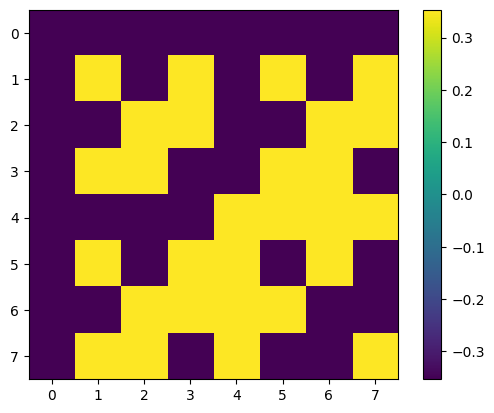

In [23]:
import numpy as np
import math  # For np.hypot
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # In the original scheme the phase was given by fix flag * π.
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, f_fit, phi_fit) in zip(couplings, rabi_freqs, fractions_fit, phases_fit):
        i, j = levels
        H_op = coupling_operator_with_phase(i, j, dim, phi_fit)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(f_fit, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

dim = 8
# couplings =  [(0, 7), (0, 6), (0, 5), (0, 2), (0, 1), (0, 2), (0, 5), (0, 4), (0, 3), (0, 7), (0, 1), (0, 4), (0, 3), (0, 7), (0, 2), (0, 6), (0, 3), (0, 5), (0, 6), (0, 7), (0, 4), (0, 3)]
# fractions =  [0.4999999950003645, 1.0000000103774978, 0.5000000603193262, 0.3918265192186481, 1.3333333713584554, 1.608173368774184, 0.4999999950002956, 0.2951672271929512, 0.2677204656249616, 0.33333332833395846, 1.0000000459574772, 1.0000000551363428, 0.43590578228311455, 0.39182655291226093, 0.9999999901533853, 0.9999999501453313, 0.49999999500438835, 1.4999999989053585, 0.9999999095398996, 0.4999999950022835, 1.0000000106431475, 1.4999999610999126]
# phases =  [0.49999999345925095, 0.49780259406974525, 0.49780258868405514, 0.4978026029595742, 0.497802593907864, 0.49780260440416413, 1.4978026058341427, 0.49780262216509974, 1.497802623933181, 1.4978026180388668, 0.4978026083913627, 0.5047517704919231, 1.5047517698081792, 1.5047517772494305, 0.5047517595870514, 1.4964915452769807, 1.4986889520719628, 0.4986889464000323, 1.4986889387256703, 1.5069491382868894, 0.5069491495365882, 1.4999999904358496]

# couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
# fractions =  [1.5, 1.0, 1.0, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.5]
# phases =  [0.4999999845501092, 0.48883814542406206, 0.5000650779374228, 0.5000650893155376, 0.5000650945829649, 0.5000650828254719, 0.5000650787782744, 0.5000650758498286, 1.5000650652330545, 1.5112919973826484, 0.4889032194331275, 0.5000650623481362, 0.5000650634805686, 1.5000650657920227, 0.48535032677653456, 0.49651217347244986, 1.4965121701439197, 1.4852852297118015, 0.4852852365612479, 1.4852852372327294, 1.499999986275988]

# # couplings =  [(2, 4), (1, 4), (3, 4), (4, 5), (4, 6), (0, 4), (4, 7), (4, 7), (0, 4), (4, 6), (4, 5), (3, 4), (4, 7), (0, 0), (4, 6), (4, 5), (3, 4), (1, 4), (4, 6), (4, 5), (3, 4), (2, 4), (4, 5), (3, 4), (3, 4), (1, 4), (1, 4), (2, 4), (2, 4)]
# # fractions =  [0.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 0.2300534561626159, 1.0, 1.5456289483429901, 0.4195693767448337, 0.40966552939826684, 0.4195693767448337, 1.0, 0, 1.0, 0.41956937674483363, 0.2951672353008666, 0.5, 1.0, 1.0, 0.6666666666666665, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# # phases =  [1.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.0, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]

couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]

# couplings =  [(0, 3), (0, 4), (0, 5), (0, 6), (0, 2), (0, 1), (0, 2), (0, 6), (0, 7), (0, 5), (0, 4), (0, 3), (0, 1), (0, 2), (0, 7), (0, 4), (0, 3), (0, 6), (0, 5), (0, 3), (0, 7), (0, 3)]
# fractions =  [1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1.0, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi, 1.0, 1, 1/3, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 0.5, 0.5, 1.0, 0.5, 1.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.5]
# phases =  [1.5, 1.5, 1.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.5]
# dim = 4
# couplings= [(0, 2), (0, 1), (0, 3), (0, 2), (0, 1)]
# fractions= [0.33333333333333326, 1.0, 0.33333333333333326, 0.3918265520306073, 0.5]
# phases= [1.5, 1.5, 1.5, 1.5, 1.5]

# couplings =  [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 1), (0, 2), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 3), (0, 4), (0, 7), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 5), (0, 6), (0, 7), (0, 6), (0, 0)]
# fractions =  [0.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.5456289483429901, 0.4195693767448337, 0.2951672353008666, 0.33333333333333326, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 1.0, 0.2163468959387855, 0.33333333333333337, 0.2951672353008666, 0.4195693767448337, 1.0, 1.0, 0.5640942168489749, 0.5, 0.5, 0.3918265520306073, 1.0, 1.0, 1.3918265520306072, 0.28043779800754365, 0.18642949867733732, 1.0, 1.0, 1.214292504567932, 0.26772047280122996, 1.0, 1.0, 1.7048327646991335, 1.0, 0]
# phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.0]


print(len(couplings))
fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)

# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# Build the target unitary using the original pulses.
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()

In [71]:
2.0 * np.arcsin(np.sqrt(2/3))/np.pi


0.6081734479693928

# Optimizer


Target Unitary (rounded):
[[-0.5-0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5-0.j  0.5+0.j  0.5+0.j -0.5-0.j]]


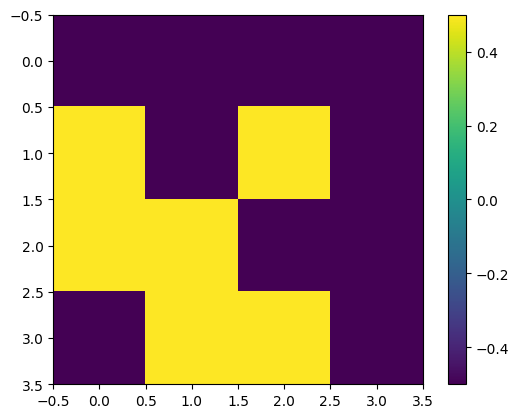

Original sequence length: 10
Original error (should be 0): 0.0
  Trying removal of pulse 9: err = 1.32e-11
  → Pulse 9 removed (new length 9)
  Trying removal of pulse 8: err = 1.92e-07
  → Pulse 8 removed (new length 8)
  Trying removal of pulse 7: err = 1.05e-07
  → Pulse 7 removed (new length 7)
  Trying removal of pulse 6: err = 6.76e-08
  → Pulse 6 removed (new length 6)
  Trying removal of pulse 5: err = 6.76e-08
  → Pulse 5 removed (new length 5)
  Trying removal of pulse 4: err = 2.61e+00
  Trying removal of pulse 3: err = 7.32e-01
  Trying removal of pulse 2: err = 2.45e+00
  Trying removal of pulse 1: err = 2.45e+00
  Trying removal of pulse 0: err = 1.08e+00
No further removals possible within threshold.

Optimized sequence length: 5
Final error: 6.757595872212889e-08


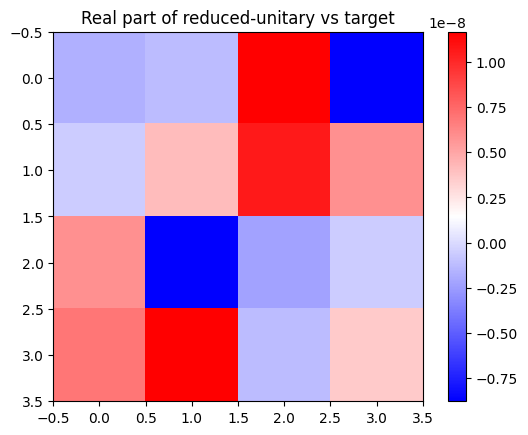

In [28]:
import numpy as np
import math
from scipy.linalg import expm, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import numpy as np
import math  # For np.hypot
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # In the original scheme the phase was given by fix flag * π.
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

dim = 8
couplings =  [(0, 7), (0, 3), (0, 6), (0, 4), (0, 5), (0, 2), (0, 1), (0, 2), (0, 5), (0, 4), (0, 6), (0, 3), (0, 7), (0, 1), (0, 2), (0, 4), (0, 3), (0, 7), (0, 2), (0, 5), (0, 6), (0, 3), (0, 5), (0, 4), (0, 6), (0, 7), (0, 4), (0, 6), (0, 3), (0, 6), (0, 0), (0, 0)]
fractions =  [1.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 0.7699465438373841, 0.45437105165701, 0.4195693767448337, 0.2951672353008666, 0.33333333333333326, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 1.0, 0.33333333333333326, 0.3918265520306073, 1.0, 1.0, 1.6666666666666667, 0.49999999999999983, 1.0, 1.0, 1.6081734479693928, 0.5000000000000002, 1.0, 1.0, 1.0, 1.0, 0, 0]
phases =  [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0]
fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)
dim = 4
couplings =  [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 1), (0, 2), (0, 3), (0, 2), (0, 0)]
fractions =  [1.5, 0.3918265520306073, 0.6666666666666667, 0.3918265520306073, 0.5, 1.0, 1.0, 1.0, 1.0, 0]
phases =  [1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.0]
fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# Build the target unitary using the original pulses.
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()

def compute_error(x, couplings, rabi_freqs, U_target, dim):
    """
    x = [f0, f1, ..., f_{M-1}, phi0, phi1, ..., phi_{M-1}]
    returns Frobenius norm ||U_seq(params) - U_target||.
    """
    M = len(couplings)
    fracs  = x[:M]
    phis   = x[M:]
    # print(phis)
    U_seq  = unitary(couplings, rabi_freqs, fracs, phis, dim)
    return norm(U_seq - U_target, 'fro')

def optimize_sequence(couplings, rabi_freqs, init_fracs, init_phis,
                      U_target, dim,
                      bounds_frac=[(0,2)], bounds_phi=[(0,2)],
                      maxiter=10000):
    M = len(couplings)
    x0 = np.hstack([init_fracs, init_phis])
    # build bounds arrays
    bnds = bounds_frac * M + bounds_phi * M
    res = minimize(
        compute_error, x0,
        args=(couplings, rabi_freqs, U_target, dim),
        method='L-BFGS-B',
        bounds=bnds,
        options={'maxiter': maxiter}
    )
    fracs_opt = res.x[:M]
    phis_opt  = res.x[M:]
    return fracs_opt, phis_opt, res.fun

def reduce_sequence(couplings, rabi_freqs, fracs, phis,
                    U_target, dim,
                    error_threshold=1e-3):
    """
    Greedily try 
    
    removing each pulse; if after re-optimizing the remaining pulses
    the error is below threshold, accept the removal and restart.
    """
    changed = True
    while changed and len(couplings) > 1:
        changed = False
        for i in range(len(couplings))[::-1]:
            # build trial sequence with pulse i removed
            c_trial = couplings[:i] + couplings[i+1:]
            f_trial = fracs[:i] + fracs[i+1:]
            p_trial = phis[:i]  + phis[i+1:]
            # re-optimize
            f_opt, p_opt, err = optimize_sequence(
                c_trial, rabi_freqs[:len(c_trial)],
                f_trial, p_trial,
                U_target, dim
            )
            print(f"  Trying removal of pulse {i}: err = {err:.2e}")
            if err < error_threshold:
                print(f"  → Pulse {i} removed (new length {len(c_trial)})")
                couplings = c_trial
                fracs     = list(f_opt)
                phis      = list(p_opt)
                rabi_freqs= rabi_freqs[:len(c_trial)]
                changed   = True
                break
        if not changed:
            print("No further removals possible within threshold.")
    return couplings, fracs, phis


U_target = A2
# show original
print("Original sequence length:", len(couplings))
print("Original error (should be 0):",
      compute_error(np.hstack([fractions, phases]),
                    couplings, rabi_freqs, U_target, dim))

# try to reduce
coupl_opt, fracs_opt, phis_opt = reduce_sequence(
    couplings, rabi_freqs, fractions, phases,
    U_target, dim,
    error_threshold=1e-1
)


print("\nOptimized sequence length:", len(coupl_opt))
print("Final error:",
      compute_error(np.hstack([fracs_opt, phis_opt]),
                    coupl_opt, rabi_freqs[:len(coupl_opt)],
                    U_target, dim))

# (optional) visualize
U_red = unitary(coupl_opt, rabi_freqs[:len(coupl_opt)],
                       fracs_opt, phis_opt, dim)
plt.figure()
plt.title("Real part of reduced-unitary vs target")
plt.imshow(np.real(U_red - U_target), cmap='bwr')
plt.colorbar()
plt.show()


In [30]:
print('couplings = ',coupl_opt)
print('fractions = ',fracs_opt)
print('phases = ',phis_opt)

couplings =  [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
fractions =  [0.4999999966799622, 1.6081734396554592, 1.3333333302779544, 0.3918265429261131, 1.4999999933448858]
phases =  [1.49999998292025, 1.4999999845867689, 0.4999999841696292, 1.4999999845868428, 1.4999999829200845]


# Best result so far

In [4]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    return np.pi * f / Omega if Omega else 0.0

def unitary(couplings, rabi_freqs, fractions, phases, dim):
    U = np.eye(dim, dtype=complex)
    for (levels, Ω, f, φ) in zip(couplings, rabi_freqs, fractions, phases):
        i, j = levels
        H = 0.5 * Ω * coupling_operator_with_phase(i, j, dim, φ * np.pi)
        U = expm(-1j * H * pulse_duration_for_fraction(f, Ω)) @ U
    return U

def compute_error(x, couplings, rabi_freqs, U_target, dim):
    M = len(couplings)
    fracs = x[:M]
    phis = x[M:]
    return norm(unitary(couplings, rabi_freqs, fracs, phis, dim) - U_target, 'fro')

def optimize_sequence(couplings, rabi_freqs, fracs, phis, U_target, dim, maxiter=500):
    M = len(couplings)
    x0 = np.hstack([fracs, phis])
    bnds = [(0, 2)] * M + [(0, 2)] * M
    res = minimize(compute_error, x0, args=(couplings, rabi_freqs, U_target, dim),
                   method='L-BFGS-B', bounds=bnds, options={'maxiter': maxiter})
    return res.x[:M], res.x[M:], res.fun

def reduce_fractions(couplings, rabi_freqs, fracs, phis, U_target, dim, error_threshold=1e-3):
    changed = True
    while changed:
        changed = False
        for i in range(len(fracs)):
            if fracs[i] <= 1:
                continue
            trial_fracs = fracs.copy()
            print(trial_fracs)
            trial_fracs[i] = fracs[i] % 1
            print(trial_fracs)
            opt_fracs, opt_phis, err = optimize_sequence(couplings, rabi_freqs, trial_fracs, phis, U_target, dim)
            print(opt_fracs)
            if err < error_threshold:
                fracs, phis = opt_fracs.tolist(), opt_phis.tolist()
                changed = True
                break
        if not changed:
            print('no further fraction reductions')
    return fracs, phis

# example usage with provided data
dim = 8
couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
rabi_freqs = [1] * len(couplings)

U_target = unitary(couplings, rabi_freqs, fractions, phases, dim)
print('initial error', compute_error(np.hstack([fractions, phases]), couplings, rabi_freqs, U_target, dim))

reduced_fracs, reduced_phis = reduce_fractions(couplings, rabi_freqs, fractions, phases, U_target, dim)
print('final error', compute_error(np.hstack([reduced_fracs, reduced_phis]), couplings, rabi_freqs, U_target, dim))
print('reduced fractions', reduced_fracs)


initial error 0.0
[1.5, 1, 1.0, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
[0.5, 1, 1.0, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
[1.5        0.99999999 1.         1.49999999 0.39182655 0.66666666
 1.39182655 0.99999998 1.         0.5        0.5        0.5
 1.         1.5        1.         1.5        1.         1.49999999
 1.5        0.99999999 1.49999999]
[1.5000000022119933, 0.9999999923068142, 0.9999999999178254, 1.4999999853948711, 0.39182654942598544, 0.6666666624198961, 1.3918265476291547, 0.9999999815302975, 0.9999999959651839, 0.4999999959699349, 0.4999999989577766, 0.4999999959311516, 0.999999997761109, 1.4999999980130174, 0.9999999997771669, 1.4999999959303363, 1.0000000040066614, 1.4999999937418427, 1.4999999953816476, 0.9999999949085898, 1.4999999921007396]
[0.5000000022119933, 0.9999999923068142, 0.9999999

KeyboardInterrupt: 

In [12]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import minimize

def coupling_operator_with_phase(i, j, d, p):
    M = np.zeros((d, d), dtype=complex)
    M[i, j] = np.exp(1j * p)
    M[j, i] = np.exp(-1j * p)
    return M

def pulse_duration(f, Ω):
    return np.pi * f / Ω if Ω else 0.0

def unitary(C, Ωs, Fs, Ps, d):
    U = np.eye(d, dtype=complex)
    for (l, Ω, f, p) in zip(C, Ωs, Fs, Ps):
        i, j = l
        H = 0.5 * Ω * coupling_operator_with_phase(i, j, d, p * np.pi)
        U = expm(-1j * H * pulse_duration(f, Ω)) @ U
    return U

def err(x, C, Ωs, Ut, d):
    m = len(C)
    Fs, Ps = x[:m], x[m:]
    return norm(unitary(C, Ωs, Fs, Ps, d) - Ut, 'fro') + 0.01*norm(Fs)

def optimize(C, Ωs, Fs0, Ps0, Ut, d, bnds, it=600):
    m = len(C)
    x0 = np.hstack([Fs0, Ps0])
    r = minimize(err, x0, args=(C, Ωs, Ut, d), method='L-BFGS-B', bounds=bnds, options={'maxiter': it})
    return r.x[:m], r.x[m:], r.fun

def reduce_fractions(C, Ωs, Fs, Ps, Ut, d, thr=1e-3):
    m = len(Fs)
    while True:
        changed = False
        print(Fs)
        for i in range(m):
            if Fs[i] <= 1: 
                continue
            target = Fs[i] % 1
            print(target)
            Fs_trial = Fs.copy(); Fs_trial[i] = target
            print(Fs_trial)
            bnds = [(0, 2)] * m + [(0, 2)] * m
            bnds[i] = (target, target)
            Fs_opt, Ps_opt, e = optimize(C, Ωs, Fs_trial, Ps, Ut, d, bnds)
            if e < thr:
                Fs, Ps = Fs_opt.tolist(), Ps_opt.tolist()
                print(Fs)
                changed = True
                break
        if not changed:
            break
    return Fs, Ps

dim = 8
C = [(0,6),(0,1),(0,3),(0,5),(0,4),(0,2),(0,4),(0,5),(0,7),(0,3),(0,1),(0,2),(0,4),(0,7),(0,1),(0,5),(0,3),(0,6),(0,7),(0,1),(0,6)]
Fs = [1.5,1,1,1.5,2*np.arcsin(np.sqrt(1/3))/np.pi,2/3,1+2*np.arcsin(np.sqrt(1/3))/np.pi,1,1,0.5,0.5,0.5,1,1.5,1,1.5,1,1.5,1.5,1,1.5]
Ps = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,0.5,0.5,0.5,1.5,0.5,0.5,1.5,1.5,0.5,1.5,1.5]
Ωs = [1]*len(C)

Ut = unitary(C, Ωs, Fs, Ps, dim)
print('initial error:', err(np.hstack([Fs, Ps]), C, Ωs, Ut, dim))

Fs_red, Ps_red = reduce_fractions(C, Ωs, Fs, Ps, Ut, dim)
print('final error:', err(np.hstack([Fs_red, Ps_red]), C, Ωs, Ut, dim))
print('reduced fractions:', Fs_red)


initial error: 0.051995339831813814
[1.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 1.5, 1, 1.5, 1.5, 1, 1.5]
0.5
[0.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 1.5, 1, 1.5, 1.5, 1, 1.5]
0.5
[1.5, 1, 1, 0.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 1.5, 1, 1.5, 1.5, 1, 1.5]
0.39182655203060723
[1.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 0.39182655203060723, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 1.5, 1, 1.5, 1.5, 1, 1.5]
0.5
[1.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 0.5, 1, 1.5, 1, 1.5, 1.5, 1, 1.5]
0.5
[1.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 0.5, 1, 1.5, 1.5, 1, 1.5]
0.5
[1.5, 1, 1, 1.5, 0.3918265520306073, 0.6666666666666666, 1.3918265520306072, 1, 1, 0.5, 0.5, 0.5, 1, 1.5, 1, 1.5,